In [1]:
import os
import numpy as np
from _tools import load_data
from _tools import DSSClass

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
pwd = os.path.dirname(os.path.realpath('python'))
os.chdir(pwd)
master_path = os.path.abspath(os.path.join(pwd, 'LVTestCase/Master.dss'))
data_path = os.path.abspath(os.path.join(pwd, 'Daily_1min_100profiles'))
data = load_data(data_path)

dss = DSSClass(master_path)
dss.set_load_shapes(data, True)
os.chdir(pwd)

dss.solve()

> Initialising DSSClass
> Initialisation successful
> Loading circuit


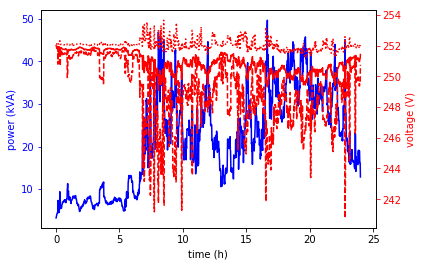

In [3]:
pq, vi = dss.get_monitor_data()

total_loads = np.abs(np.array([l['P1 (kW)'].as_matrix() + l['Q1 (kvar)'].as_matrix() for l in pq])).T
total_voltages = np.array([v['V1'].as_matrix() for v in vi])

total_load = np.array(np.sum(total_loads, 1), ndmin=2).T
v_mean = np.mean(total_voltages, 0)
v_min = np.max(total_voltages, 0)
v_max = np.min(total_voltages, 0)
t = np.arange(total_load.size) / 60.0

fig, ax1 = plt.subplots()
ax1.plot(t, total_load, 'b')
ax1.set_ylabel('power (kVA)', color='b')
ax1.tick_params('y', colors='b')
ax1.set_xlabel('time (h)')

ax2 = ax1.twinx()
ax2.plot(t, v_mean, 'r')
ax2.plot(t, v_max, 'r--')
ax2.plot(t, v_min, 'r:')
ax2.set_ylabel('voltage (V)', color='r')
ax2.tick_params('y', colors='r')

plt.show()

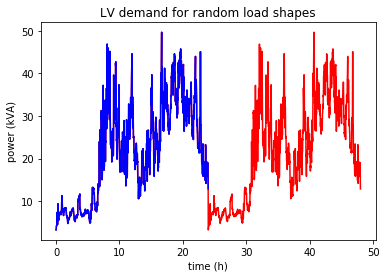

In [4]:
# Generate initial random load shapes

profile_reps = 2
t_rep = np.arange(t.size * profile_reps) / 60

data_rand = [np.array([np.random.rand(total_load.size * profile_reps) for _ in range(dss.load_count())]).T]
data_scale = np.true_divide(np.tile(total_load, [profile_reps, 1]), np.array(np.sum(data_rand[-1], 1), ndmin=2).T)
data_rand[-1] = data_rand[-1] * np.tile(data_scale, [1, dss.load_count()])

fig, ax1 = plt.subplots()
ax1.plot(t_rep, np.sum(data_rand[-1], 1), 'r')
ax1.plot(t, total_load, 'b')
ax1.set_ylabel('power (kVA)')
ax1.set_xlabel('time (h)')
ax1.set_title('LV demand for random load shapes')
plt.show()

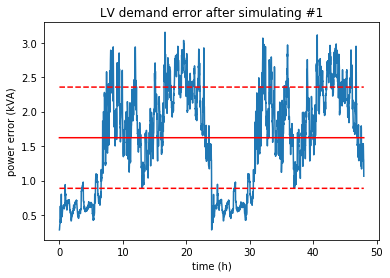

mean: 1.622020; std: 0.734252


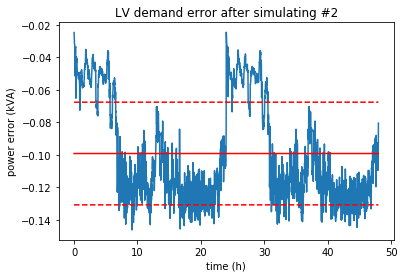

mean: -0.099267; std: 0.031583


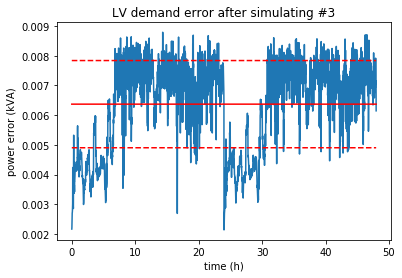

mean: 0.006370; std: 0.001466


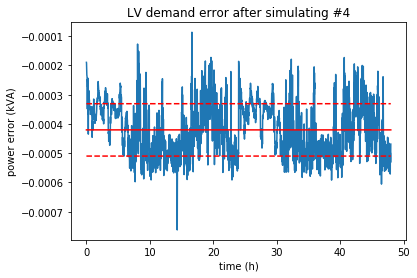

mean: -0.000420; std: 0.000089


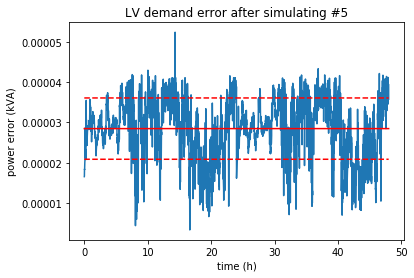

mean: 0.000028; std: 0.000008


In [5]:
# Correct each load to reduce network load error
iter_max = 10

data_rand = [data_rand[0]]

i = 0
while True:
    # Apply and simulate loadshapes
    dss.set_load_shapes(data_rand[-1])
    dss.solve()
    
    # Obtain data
    pq, vi = dss.get_monitor_data()
    data_rand_result = np.abs(np.array([l['P1 (kW)'].as_matrix() + l['Q1 (kvar)'].as_matrix() for l in pq])).T
    # Compute error and error statistics
    load_error = np.sum(data_rand_result, 1) - np.tile(total_load, [profile_reps, 1]).squeeze()
    mean_error = np.mean(load_error)
    std_error = np.std(load_error)
    
    fig, ax1 = plt.subplots()
    ax1.plot(t_rep, load_error)
    ax1.plot(t_rep, np.ones(load_error.size) * mean_error, 'r')
    ax1.plot(t_rep, np.ones(load_error.size) * (mean_error + std_error), 'r--')
    ax1.plot(t_rep, np.ones(load_error.size) * (mean_error - std_error), 'r--')
    ax1.set_ylabel('power error (kVA)')
    ax1.set_xlabel('time (h)')
    ax1.set_title('LV demand error after simulating #{}'.format(i+1))
    plt.show()
    print('mean: {:.6f}; std: {:.6f}'.format(mean_error, std_error))
    
    # Subtract error
    load_delta = np.multiply(data_rand[-1], np.tile(load_error, [dss.load_count(), 1]).T)
    load_delta = np.divide(load_delta, np.tile(np.sum(data_rand[-1], 1), [dss.load_count(), 1]).T)
    data_rand.append(data_rand[-1] - load_delta)

    i += 1
    if iter_max < i or (np.round(mean_error + std_error, 4) == 0 and np.round(mean_error - std_error, 4) == 0):
        break
